# Quickstart
* [tutorial](http://lightkurve.keplerscience.org/tutorials/1.02-target-pixel-files.html)

Unofficial using TPF of EPIC249622103 in K2-C15

* [paper](https://arxiv.org/abs/1803.05056)

In [1]:
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
from astropy.io import fits
import pandas as pd

In [3]:
from lightkurve import KeplerTargetPixelFile

tpf_unofficial= 'ktwo249622103-unofficial-tpf.fits'
tpf = KeplerTargetPixelFile(tpf_unofficial) #, quality_bitmask='hardest')
lc = tpf.to_lightcurve(aperture_mask='all');
lc = lc.remove_nans().remove_outliers(sigma=3.5)

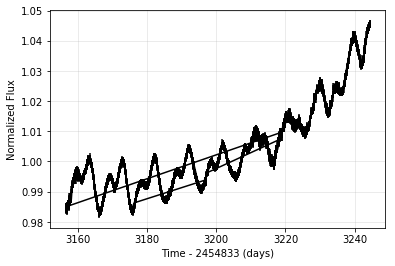

In [4]:
lc.plot(linestyle='solid');

Note: using all pixels is not ideal. See also [this notebook](http://localhost:8890/notebooks/data/Jerome/notebook/official%20vs%20unofficial%20tpf.ipynb)

In [5]:
tpf.to_lightcurve(aperture_mask='pipeline')

KeplerLightCurve(EPIC: None)

Note: aperture mask is null!

In [6]:
tpf.pipeline_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False]])

## How does the Vanderburg & Johnson 2014 K2SFF method work?

* [link](http://lightkurve.keplerscience.org/tutorials/motion-correction/replicate-vanderburg-2014-k2sff.html)


Instead of using mask in [K2SFF website](http://archive.stsci.edu/hlsps/k2sff/) (C15 data not yet available in K2SFF website), use default aperture.

Diagnostic data

mean-subtract the provided x−y centroids, assigning them column and row identifiers, then rotate the coordinates into their major and minor axes

In [7]:
col = lc.centroid_col
col = col - np.mean(col)
row = lc.centroid_row
row = row - np.mean(row)

In [8]:
def _get_eigen_vectors(centroid_col, centroid_row):
    '''get the eigenvalues and eigenvectors given centroid x, y positions'''
    centroids = np.array([centroid_col, centroid_row])
    eig_val, eig_vec = np.linalg.eigh(np.cov(centroids))
    return eig_val, eig_vec

In [9]:
def _rotate(eig_vec, centroid_col, centroid_row):
    '''rotate the centroids into their predominant linear axis'''
    centroids = np.array([centroid_col, centroid_row])
    return np.dot(eig_vec, centroids)

In [10]:
eig_val, eig_vec = _get_eigen_vectors(col, row)
v1, v2 = eig_vec

In [11]:
platescale = 4.0 # The Kepler plate scale; has units of arcseconds / pixel

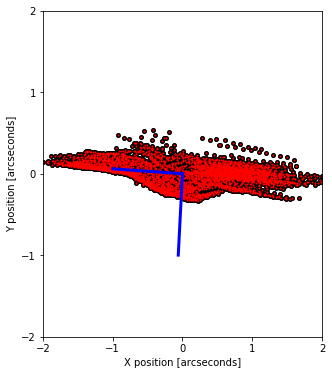

In [12]:
pl.figure(figsize=(5, 6))
pl.plot(col * platescale, row * platescale, 'ko', ms=4)
pl.plot(col * platescale, row * platescale, 'ro', ms=1)
pl.xticks([-2, -1,0, 1, 2])
pl.yticks([-2, -1,0, 1, 2])
pl.xlabel('X position [arcseconds]')
pl.ylabel('Y position [arcseconds]')
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.plot([0, v1[0]], [0, v1[1]], color='blue', lw=3)
pl.plot([0, v2[0]], [0, v2[1]], color='blue', lw=3);

In [13]:
rot_colp, rot_rowp = _rotate(eig_vec, col, row) #units in pixels

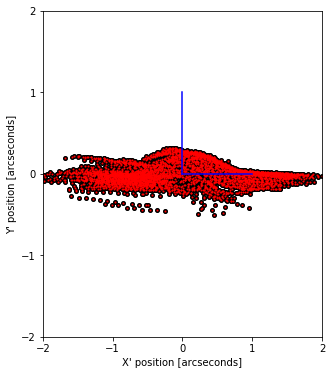

In [14]:
pl.figure(figsize=(5, 6))
pl.plot(rot_rowp * platescale, rot_colp * platescale, 'ko', ms=4)
pl.plot(rot_rowp * platescale, rot_colp * platescale, 'ro', ms=1)
pl.xticks([-2, -1,0, 1, 2])
pl.yticks([-2, -1,0, 1, 2])
pl.xlabel("X' position [arcseconds]")
pl.ylabel("Y' position [arcseconds]")
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.plot([0, 1], [0, 0], color='blue')
pl.plot([0, 0], [0, 1], color='blue');

Calculate arclength. Fit a 5th order polynomial to the rotated coordinates.

In [15]:
z = np.polyfit(rot_rowp, rot_colp, 5)
p5 = np.poly1d(z)
p5_deriv = p5.deriv()

In [16]:
x0_prime = np.min(rot_rowp)
xmax_prime = np.max(rot_rowp)
x_dense = np.linspace(x0_prime, xmax_prime, 2000)

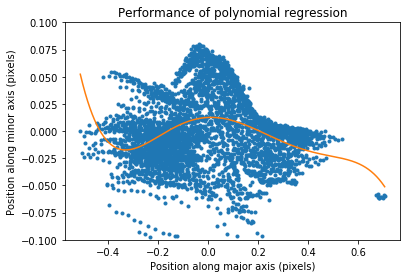

In [17]:
pl.plot(rot_rowp, rot_colp, '.')
pl.plot(x_dense, p5(x_dense))
pl.ylabel('Position along minor axis (pixels)')
pl.xlabel('Position along major axis (pixels)')
pl.title('Performance of polynomial regression')
pl.ylim(-0.1, 0.1);

[Bias-Variance Tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

In [18]:
@np.vectorize
def arclength(x):
    '''Input x1_prime, get out arclength'''
    gi = x_dense <x
    s_integrand = np.sqrt(1 + p5_deriv(x_dense[gi]) ** 2)
    s = np.trapz(s_integrand, x=x_dense[gi])
    return s

apply a high-pass filter to the raw lightcurve data. We follow the original paper by using BSplines with 1.5 day breakpoints. You can also apply data exclusion at this stage.

 find the weighted least square spline for a given set of knots, t. We supply interior knots as knots on the ends are added automatically, as stated in the interpolate.splrep() docstring.

In [19]:
from scipy.interpolate import BSpline
from scipy import interpolate

time = lc.time
flux = lc.flux
flux_err = lc.flux_err

interior_knots = np.arange(time[0]+1.5, time[0]+6, 1.5)
t,c,k = interpolate.splrep(time, flux, s=0, task=-1, t=interior_knots)
bspl = BSpline(t,c,k)

ValueError: Error on input data

# STUPID FIX

> res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)

requires x vector (i.e. time) is increasing in order

Note that the plot above has weird connecting lines which implies some arrays are not in order!

In [20]:
time[:10]

array([3175.77310826, 3176.05915619, 3175.50749245, 3175.52792445,
       3175.54835644, 3175.56878844, 3175.58922033, 3175.60965242,
       3175.63008442, 3175.65051631])

Note that there are 89 other unsorted values!

In [21]:
np.sum(pd.Series(time).diff()<0)

89

## Solution: sort t, f, f_err

In [33]:
centroid_col, centroid_row = lc.centroid_col, lc.centroid_row

In [36]:
df = pd.DataFrame(np.c_[flux,flux_err,centroid_col,centroid_row],index=time)
df = df.sort_index()
df.columns = ['f', 'ferr', 'centroid_col', 'centroid_row']

In [38]:
t_sort,f_sort,ferr_sort = df.index, df.f.values, df.ferr.values
centroid_col_sort, centroid_row_sort = df.centroid_col.values, df.centroid_row.values

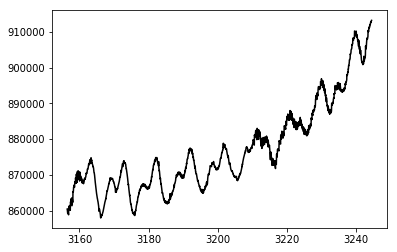

In [39]:
pl.plot(t_sort,f_sort,'k')

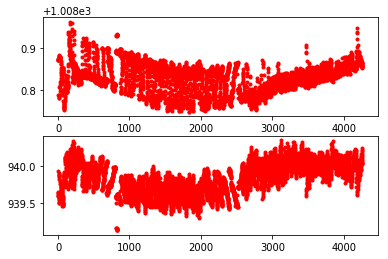

In [45]:
fig, ax = pl.subplots(2,1)
ax[0].plot(lc.centroid_row,'.r')
#ax[0].plot(centroid_row_sort,'-b')
ax[1].plot(lc.centroid_col,'.r')
#ax[1].plot(centroid_col_sort,'-b')

## APPLY FIX (use sorted values)!

In [27]:
from scipy.interpolate import BSpline
from scipy import interpolate

time = t_sort
flux = f_sort
flux_err = ferr_sort

thruster_period = 1.5 #day
interior_knots = np.arange(time[0]+thruster_period, time[0]+6, thruster_period)
t,c,k = interpolate.splrep(time, flux, s=1, task=-1, t=interior_knots)
bspl = BSpline(t,c,k)

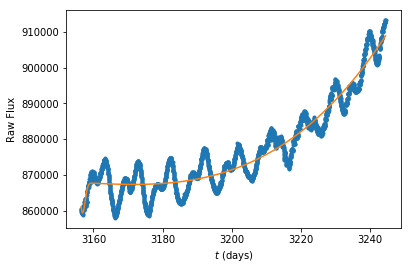

In [57]:
pl.plot(time, flux, '.')
pl.plot(time, bspl(time))
pl.xlabel('$t$ (days)')
pl.ylabel('Raw Flux');

normalize the flux by the long-term trend.
Plot the normalized flux versus arclength to see the position-dependent flux.


In [58]:
f_norm = flux/bspl(time)

Mask the data by keeping only the good samples.

## Thruster data

apply quality mask

NO DATA FOR THRUSTER FIRES?

In [53]:
import os

def find_thruster_events(time,data,Xc,Yc,outputpath='',starname=''):
    #
    # Find events when the spacecruft thruster are fired. Usually no useful data points are gathered when this happens
    #

    diff_centroid = np.diff(Xc)**2 + np.diff(Yc)**2

    thruster_mask = diff_centroid < (1.5*np.mean(diff_centroid) + 0.*np.std(diff_centroid))
    thruster_mask1 = np.insert(thruster_mask,0, False) # this little trick helps us remove 2 data points each time instead of just 1
    thruster_mask2 = np.append(thruster_mask,False)
    thruster_mask = thruster_mask1*thruster_mask2

    time_thruster = time[thruster_mask]
    diff_centroid_thruster = diff_centroid[ thruster_mask[1:] ]

    Xc_clipped = Xc[:][thruster_mask]
    Yc_clipped = Yc[:][thruster_mask]
    time_clipped = time[:][thruster_mask]
    data_clipped = data[:][thruster_mask]


    #pl.figure('Data with / without thruster events')
    #pl.plot(time,data)
    #pl.plot(time_clipped,data_clipped)

    #pl.figure('Differential of centroid movement')
    #pl.plot(time[1:],diff_centroid)
    #pl.plot(time_thruster,diff_centroid_thruster,'*')

    #pl.figure()
    #pl.plot(time_clipped,data_clipped)
    #pl.savefig(os.path.join(outputpath,'raw_nothrusters_' + str(starname) + '.png'))
    #np.savetxt(os.path.join(outputpath, 'lightcurve_raw_nothrusters_' + str(starname) + '.txt'),np.transpose([time_clipped,np.array(data_clipped)/np.mean(data_clipped)]),header='Time, Flux')

    return [time_clipped,data_clipped,Xc_clipped,Yc_clipped]

In [55]:
t_clipp,f_clip,Xc_clip,Yc_clip = find_thruster_events(time,flux,lc.centroid_col,lc.centroid_row)

In [82]:
fits.open(tpf_unofficial)[1].data.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'D'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '88J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,8)'
    name = 'FLUX'; format = '88E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,8)'
    name = 'FLUX_ERR'; format = '88E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,8)'
    name = 'FLUX_BKG'; format = '88E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,8)'
    name = 'FLUX_BKG_ERR'; format = '88E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,8)'
    name = 'COSMIC_RAYS'; format = '88E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,8)'
    name = 'QUALITY'; format = 'J'; disp = 'B24.24'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixels'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixels'; disp = 'E14.7'
)

In [83]:
al = arclength(rot_rowp) * platescale

In [84]:
sorted_inds = np.argsort(al)

interpolating flux versus arclength position in 15 bins of means, which is a piecewise linear fit.

In [85]:
knots = np.array([np.min(al)]+
                 [np.median(splt) for splt in np.array_split(al[sorted_inds], 15)]+
                 [np.max(al)])

In [86]:
bin_means = np.array([f_sort[sorted_inds][0]]+
                     [np.mean(splt) for splt in np.array_split(f_sort[sorted_inds], 15)]+
                     [f_sort[sorted_inds][-1]])

In [88]:
zz = np.polyfit(al, f_sort,6)
sff = np.poly1d(zz)
al_dense = np.linspace(0, 4, 1000)
interp_func = interpolate.interp1d(knots, bin_means)

Text(0.5,1,'EPIC 60021426, Kp =10.3')

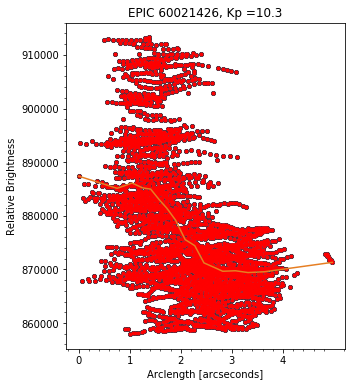

In [93]:
pl.figure(figsize=(5, 6))
pl.plot(arclength(rot_rowp)*4.0, f_sort, 'ko', ms=4)
pl.plot(arclength(rot_rowp)*4.0, f_sort, 'o', color='#3498db', ms=3)
#remove bad data (during thruster fires)
#pl.plot(arclength(rot_rowp[bi])*4.0, flux[bi], 'o', color='r', ms=3)
pl.plot(arclength(rot_rowp)*4.0, f_sort, 'o', color='r', ms=3)
pl.plot(np.sort(al), interp_func(np.sort(al)), '-', color='#e67e22')

pl.xticks([0, 1, 2, 3, 4])
pl.minorticks_on()
pl.xlabel('Arclength [arcseconds]')
pl.ylabel('Relative Brightness')
pl.title('EPIC 60021426, Kp =10.3')
#pl.xlim(0,4)
#pl.ylim(0.997, 1.002);

Apply the Self Flat Field (SFF) correction:

In [95]:
corr_flux = f_sort / interp_func(al)

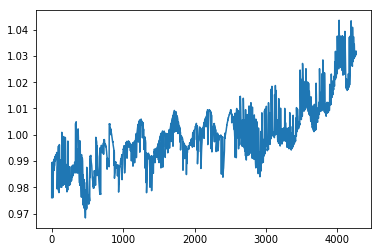

In [96]:
pl.plot(corr_flux)

## Using lightkurve
* [link](http://lightkurve.keplerscience.org/tutorials/motion-correction/replicate-vanderburg-2014-lightkurve.html)

In [97]:
from lightkurve import SFFCorrector

tpf = KeplerTargetPixelFile(tpf_unofficial)

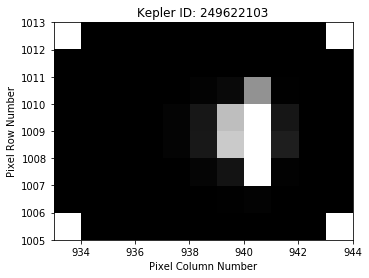

In [98]:
ax = tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='b', frame=300,
              scale='linear', cmap='gray',show_colorbar=False)
#tpf.plot(aperture_mask=VDB_J_mask, frame=300, scale='linear', cmap='gray', ax=ax, mask_color='pink');

In [100]:
lc_raw = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

In [106]:
np.sum(lc_raw.quality)

0

In [ ]:
['TARGETTABLES']